In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d prosperchuks/fakereal-logo-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/prosperchuks/fakereal-logo-detection-dataset
License(s): CC0-1.0
fakereal-logo-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fakereal-logo-detection-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

In [ ]:
data = pd.read_csv('file_mapping.csv')

In [ ]:
data['Filename'] = data['Filename'].str.replace('\\', '/')

print("The dimensions of the data is ",data.shape)
print ("The columns in our data set",data.columns.tolist())

# Check for any null values
null_check = data.isnull().values.any()

missing_values_per_column = data.isnull().sum()
print(missing_values_per_column)

# Count Fake and Genuine logos
fake_count = (data['Label'] == 'Fake').sum()
genuine_count = (data['Label'] == 'Genuine').sum()
print("Number of Fake logos:", fake_count)
print("Number of Genuine logos:", genuine_count)

The dimensions of the data is  (825, 4)
The columns in our data set ['Filename', 'Brand Name', 'Label', 'Tagline']
Filename       0
Brand Name     0
Label          0
Tagline       12
dtype: int64
Number of Fake logos: 550
Number of Genuine logos: 275


In [ ]:
#Dividing the data into test data(80%) and training data(20%)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
#Normalization (making each pixel value to fall in the range between 0 and 1)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#defining training dataset
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filename',
    y_col='Label',
    target_size=(70, 70),
    batch_size=32,
    class_mode='binary')

#defining testing dataset
validation_ds = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filename',
    y_col='Label',
    target_size=(70, 70),
    batch_size=32,
    class_mode='binary',
    shuffle=False)


Found 660 validated image filenames belonging to 2 classes.
Found 165 validated image filenames belonging to 2 classes.


In [ ]:
train_ds.class_indices

{'Fake': 0, 'Genuine': 1}

In [ ]:
# CNN model
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(70,70,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 34, 34, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 128)        

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=False, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=validation_ds,
                    steps_per_epoch=len(train_ds),
                    validation_steps=len(validation_ds),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.6591
Epoch 1: saving model to best_model.h5
21/21 [==============================] - 10s 407ms/step - loss: 0.6379 - accuracy: 0.6591 - val_loss: 0.6424 - val_accuracy: 0.6242
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.6818
Epoch 2: saving model to best_model.h5
21/21 [==============================] - 6s 290ms/step - loss: 0.5674 - accuracy: 0.6818 - val_loss: 0.5519 - val_accuracy: 0.6606
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.6727
Epoch 3: saving model to best_model.h5
21/21 [==============================] - 8s 390ms/step - loss: 0.5307 - accuracy: 0.6727 - val_loss: 0.5546 - val_accuracy: 0.6545
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.6697
Epoch 4: saving model to best_model.h5
21/21 [==============================] - 7s 317ms/step - loss: 0.5375 - ac

In [ ]:
#Best validation loss and accuracy
best_val_loss = min(history.history['val_loss'])
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Validation Accuracy: {best_val_accuracy}")

Best Validation Loss: 0.5116909742355347
Best Validation Accuracy: 0.7151514887809753


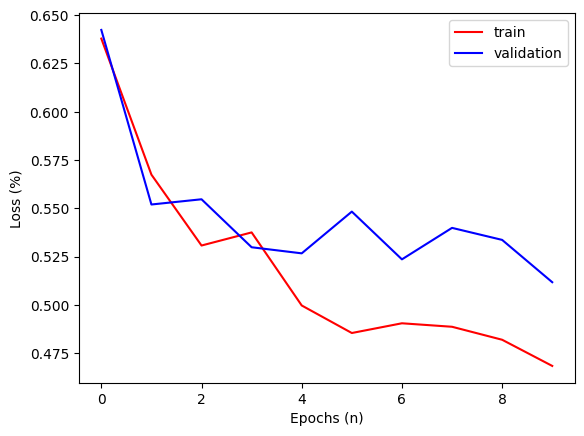

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs (n)')
plt.ylabel('Loss (%)')
plt.show()

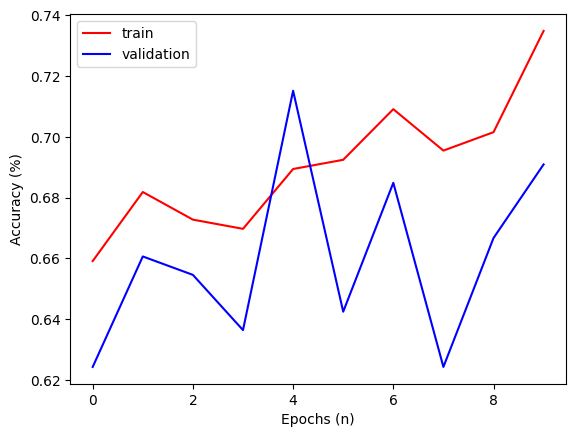

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs (n)')
plt.ylabel('Accuracy (%)')
plt.show()

1/1 [==============================] - 0s 130ms/step


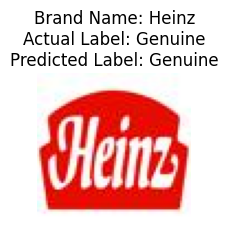

1/1 [==============================] - 0s 25ms/step


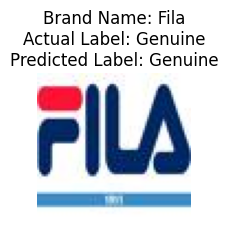

1/1 [==============================] - 0s 25ms/step


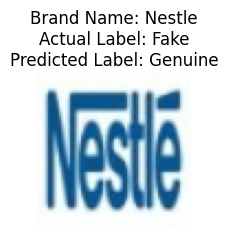

1/1 [==============================] - 0s 41ms/step


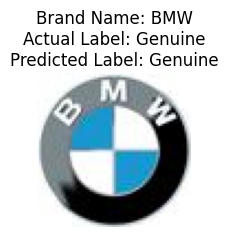

1/1 [==============================] - 0s 54ms/step


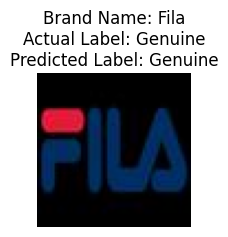

1/1 [==============================] - 0s 39ms/step


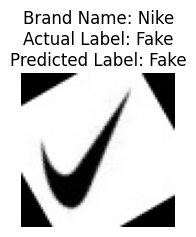

1/1 [==============================] - 0s 39ms/step


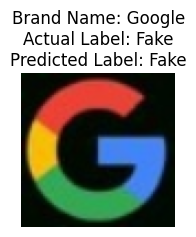

1/1 [==============================] - 0s 40ms/step


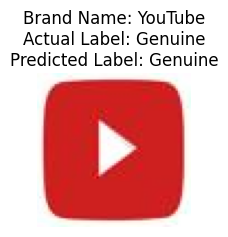

1/1 [==============================] - 0s 38ms/step


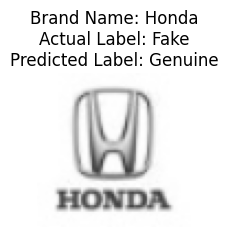

1/1 [==============================] - 0s 38ms/step


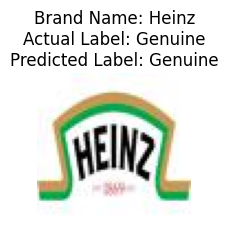

1/1 [==============================] - 0s 42ms/step


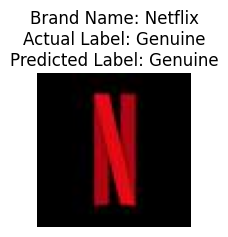

1/1 [==============================] - 0s 36ms/step


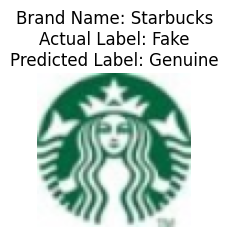

1/1 [==============================] - 0s 39ms/step


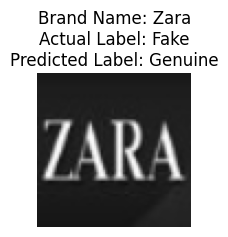

1/1 [==============================] - 0s 47ms/step


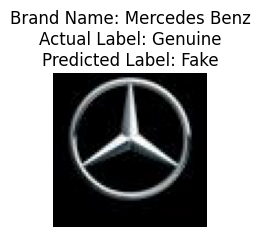

1/1 [==============================] - 0s 37ms/step


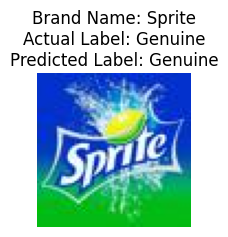

1/1 [==============================] - 0s 22ms/step


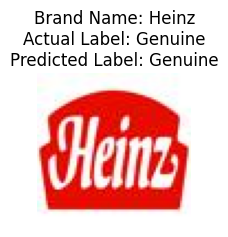

1/1 [==============================] - 0s 24ms/step


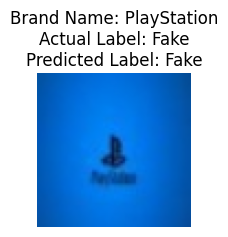

1/1 [==============================] - 0s 23ms/step


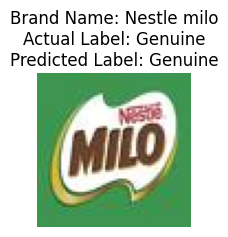

1/1 [==============================] - 0s 29ms/step


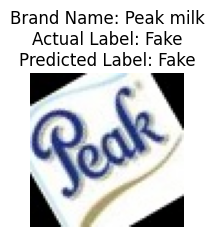

1/1 [==============================] - 0s 23ms/step


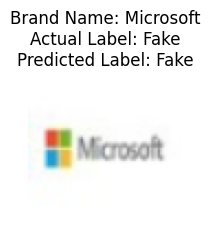

1/1 [==============================] - 0s 25ms/step


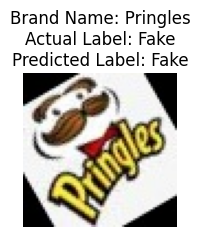

1/1 [==============================] - 0s 24ms/step


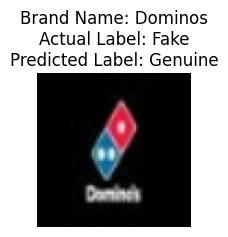

1/1 [==============================] - 0s 26ms/step


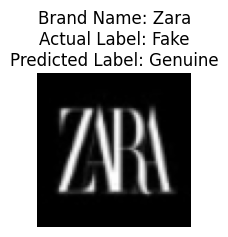

1/1 [==============================] - 0s 25ms/step


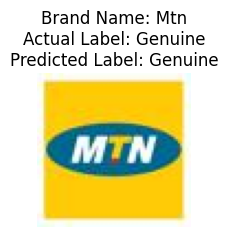

1/1 [==============================] - 0s 26ms/step


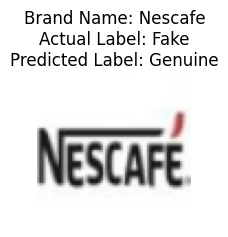

1/1 [==============================] - 0s 23ms/step


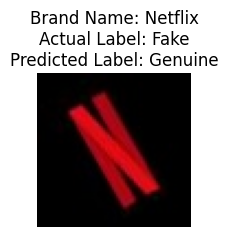

1/1 [==============================] - 0s 24ms/step


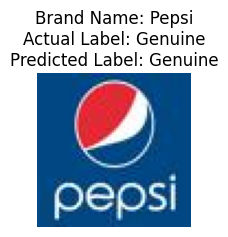

1/1 [==============================] - 0s 24ms/step


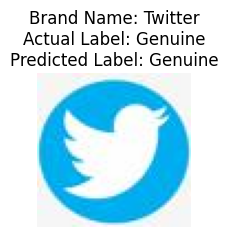

1/1 [==============================] - 0s 25ms/step


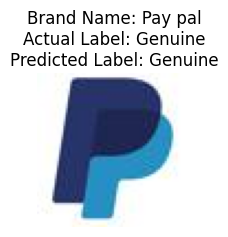

1/1 [==============================] - 0s 39ms/step


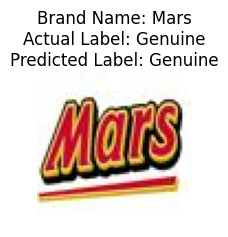

1/1 [==============================] - 0s 24ms/step


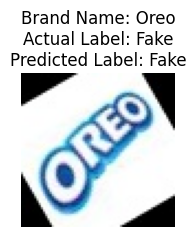

1/1 [==============================] - 0s 27ms/step


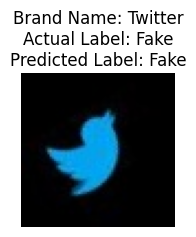

1/1 [==============================] - 0s 26ms/step


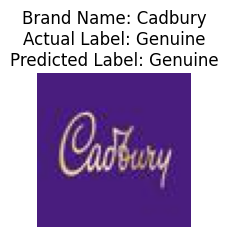

1/1 [==============================] - 0s 25ms/step


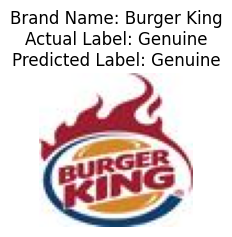

1/1 [==============================] - 0s 24ms/step


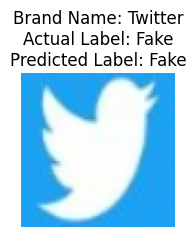

1/1 [==============================] - 0s 24ms/step


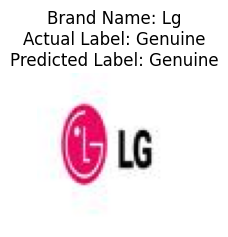

1/1 [==============================] - 0s 25ms/step


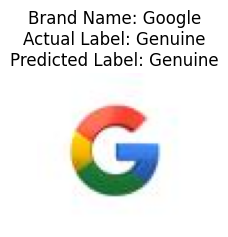

1/1 [==============================] - 0s 27ms/step


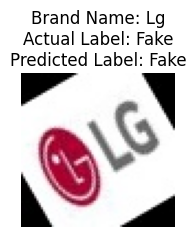

1/1 [==============================] - 0s 24ms/step


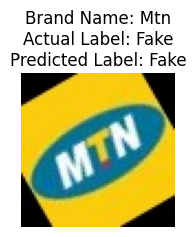

1/1 [==============================] - 0s 24ms/step


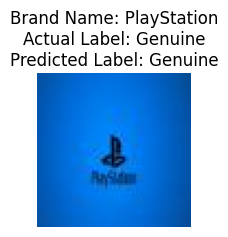

1/1 [==============================] - 0s 24ms/step


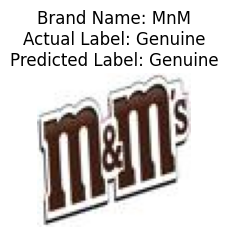

1/1 [==============================] - 0s 25ms/step


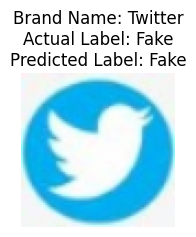

1/1 [==============================] - 0s 24ms/step


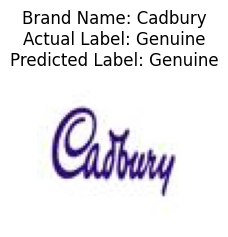

1/1 [==============================] - 0s 23ms/step


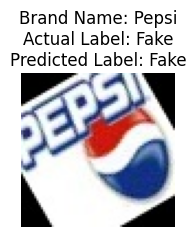

1/1 [==============================] - 0s 27ms/step


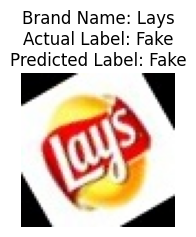

1/1 [==============================] - 0s 25ms/step


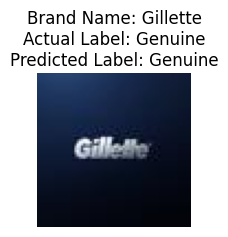

1/1 [==============================] - 0s 25ms/step


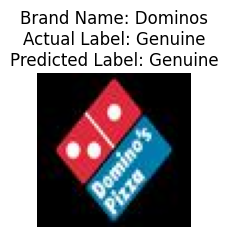

1/1 [==============================] - 0s 24ms/step


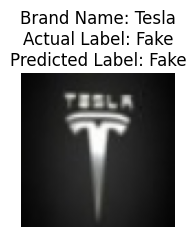

1/1 [==============================] - 0s 25ms/step


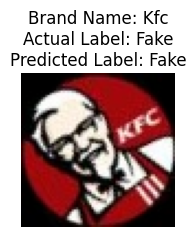

1/1 [==============================] - 0s 29ms/step


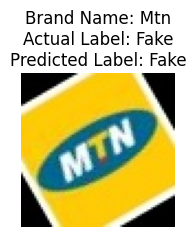

1/1 [==============================] - 0s 25ms/step


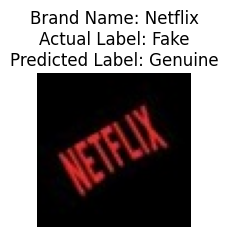

1/1 [==============================] - 0s 25ms/step


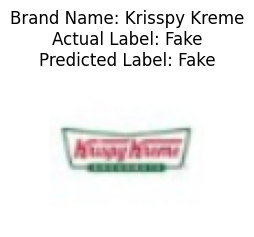

1/1 [==============================] - 0s 24ms/step


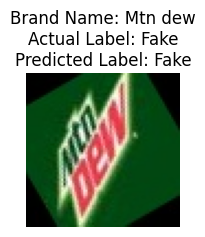

1/1 [==============================] - 0s 27ms/step


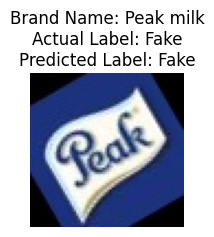

1/1 [==============================] - 0s 42ms/step


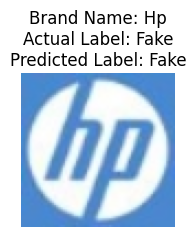

1/1 [==============================] - 0s 40ms/step


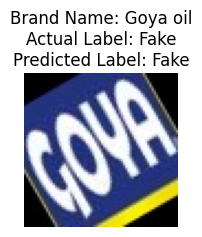

1/1 [==============================] - 0s 53ms/step


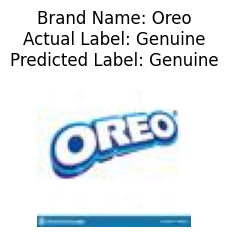

1/1 [==============================] - 0s 44ms/step


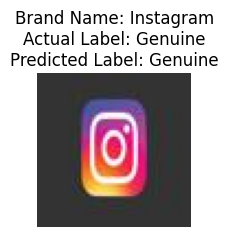

1/1 [==============================] - 0s 51ms/step


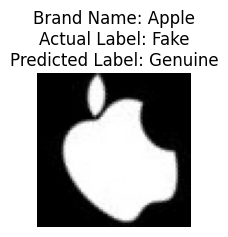

1/1 [==============================] - 0s 40ms/step


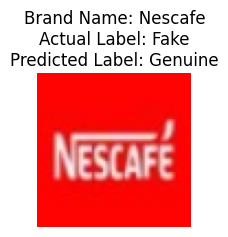

1/1 [==============================] - 0s 37ms/step


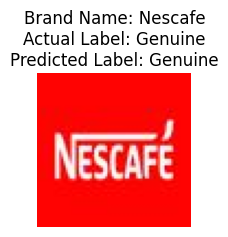

1/1 [==============================] - 0s 41ms/step


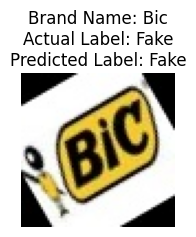

1/1 [==============================] - 0s 36ms/step


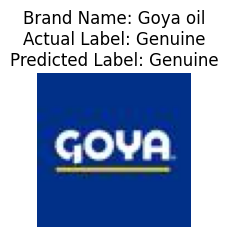

1/1 [==============================] - 0s 56ms/step


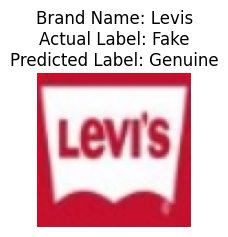

1/1 [==============================] - 0s 43ms/step


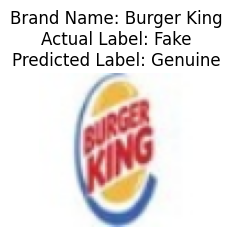

1/1 [==============================] - 0s 43ms/step


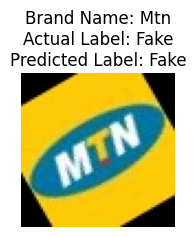

1/1 [==============================] - 0s 44ms/step


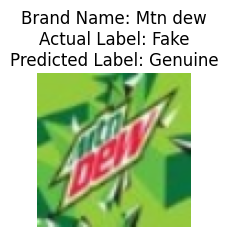

1/1 [==============================] - 0s 42ms/step


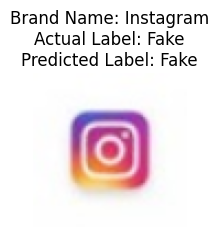

1/1 [==============================] - 0s 43ms/step


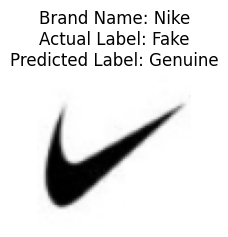

1/1 [==============================] - 0s 46ms/step


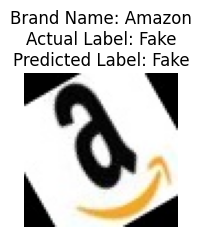

1/1 [==============================] - 0s 48ms/step


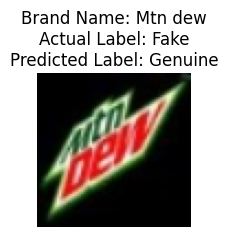

1/1 [==============================] - 0s 45ms/step


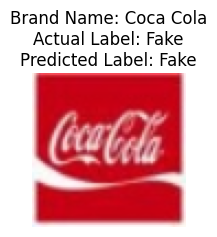

1/1 [==============================] - 0s 44ms/step


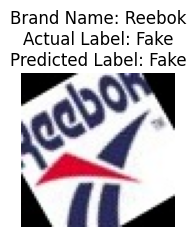

1/1 [==============================] - 0s 36ms/step


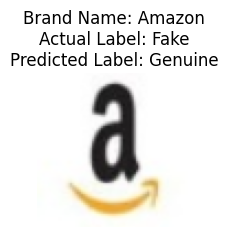

1/1 [==============================] - 0s 24ms/step


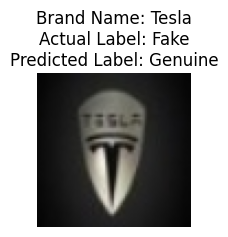

1/1 [==============================] - 0s 24ms/step


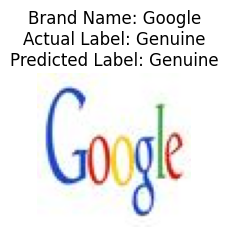

1/1 [==============================] - 0s 43ms/step


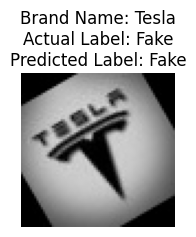

1/1 [==============================] - 0s 39ms/step


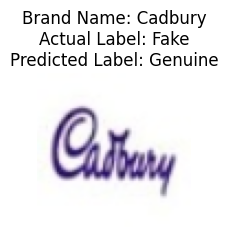

1/1 [==============================] - 0s 36ms/step


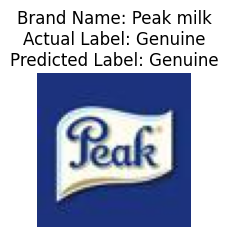

1/1 [==============================] - 0s 36ms/step


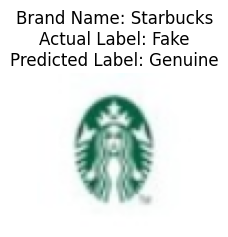

1/1 [==============================] - 0s 31ms/step


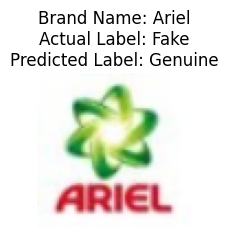

1/1 [==============================] - 0s 29ms/step


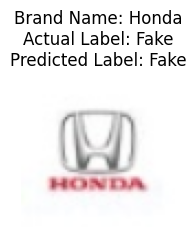

1/1 [==============================] - 0s 26ms/step


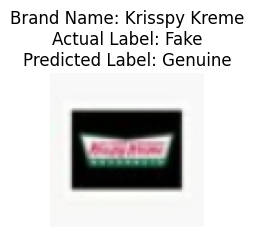

1/1 [==============================] - 0s 24ms/step


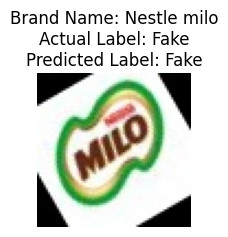

1/1 [==============================] - 0s 28ms/step


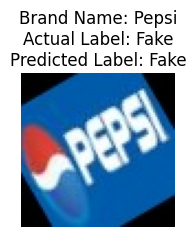

1/1 [==============================] - 0s 28ms/step


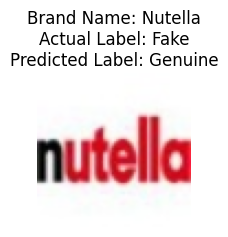

1/1 [==============================] - 0s 32ms/step


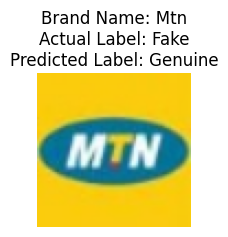

1/1 [==============================] - 0s 28ms/step


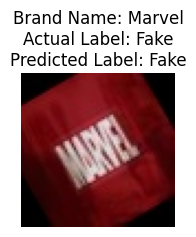

1/1 [==============================] - 0s 30ms/step


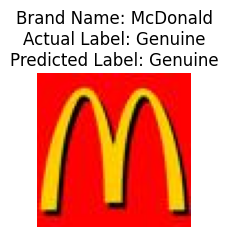

1/1 [==============================] - 0s 28ms/step


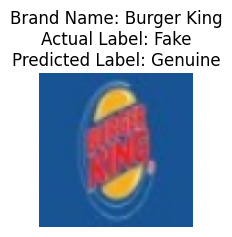

1/1 [==============================] - 0s 35ms/step


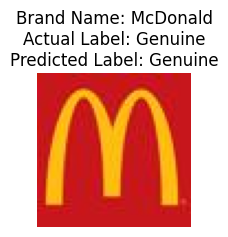

1/1 [==============================] - 0s 47ms/step


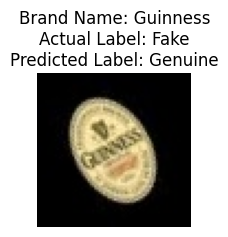

1/1 [==============================] - 0s 32ms/step


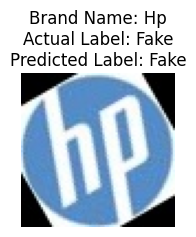

1/1 [==============================] - 0s 32ms/step


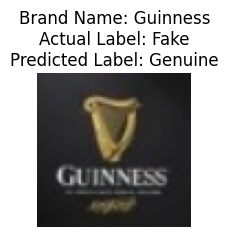

1/1 [==============================] - 0s 26ms/step


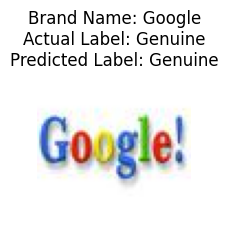

1/1 [==============================] - 0s 30ms/step


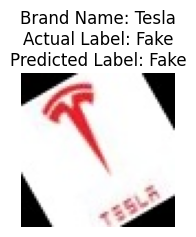

1/1 [==============================] - 0s 29ms/step


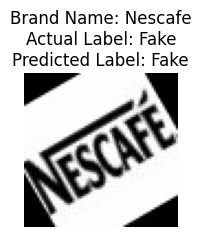

1/1 [==============================] - 0s 29ms/step


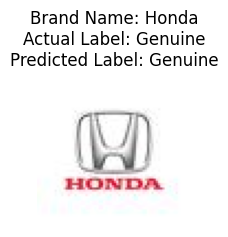

1/1 [==============================] - 0s 28ms/step


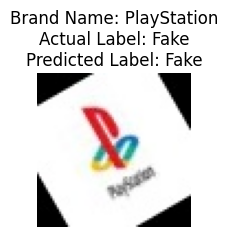

1/1 [==============================] - 0s 27ms/step


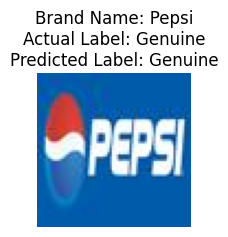

1/1 [==============================] - 0s 39ms/step


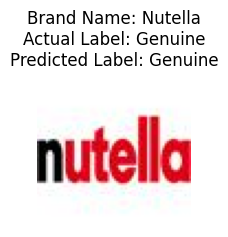

1/1 [==============================] - 0s 38ms/step


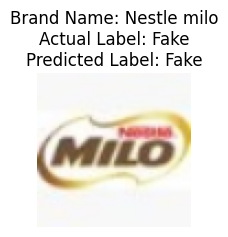

1/1 [==============================] - 0s 36ms/step


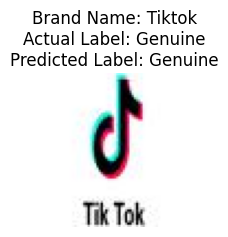

1/1 [==============================] - 0s 34ms/step


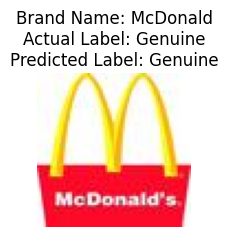

1/1 [==============================] - 0s 38ms/step


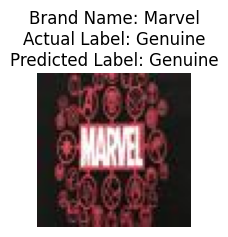

1/1 [==============================] - 0s 30ms/step


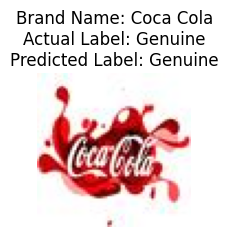

1/1 [==============================] - 0s 31ms/step


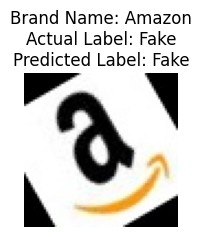

1/1 [==============================] - 0s 40ms/step


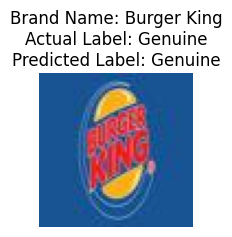

1/1 [==============================] - 0s 40ms/step


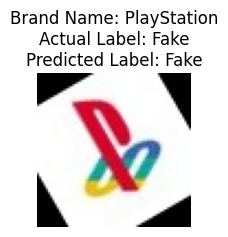

1/1 [==============================] - 0s 69ms/step


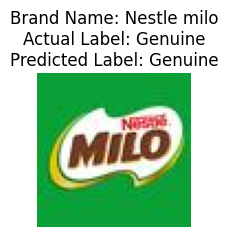

1/1 [==============================] - 0s 43ms/step


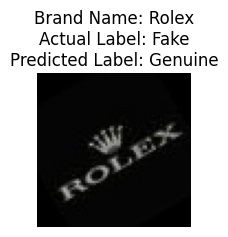

1/1 [==============================] - 0s 59ms/step


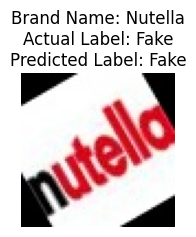

1/1 [==============================] - 0s 41ms/step


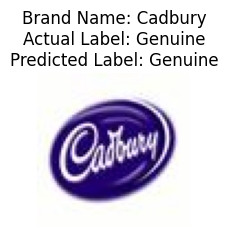

1/1 [==============================] - 0s 52ms/step


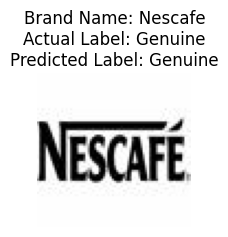

1/1 [==============================] - 0s 38ms/step


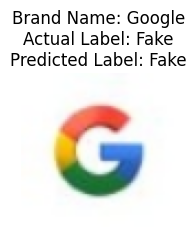

1/1 [==============================] - 0s 44ms/step


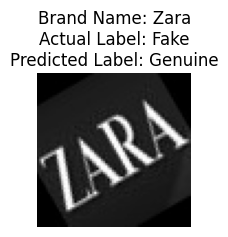

1/1 [==============================] - 0s 52ms/step


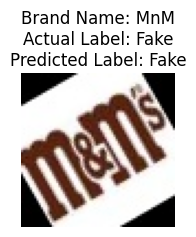

1/1 [==============================] - 0s 67ms/step


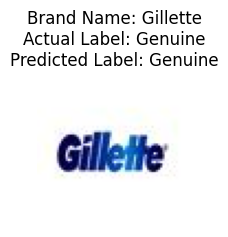

1/1 [==============================] - 0s 57ms/step


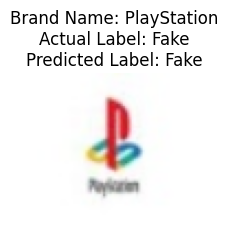

1/1 [==============================] - 0s 58ms/step


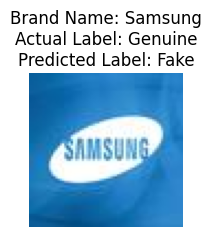

1/1 [==============================] - 0s 49ms/step


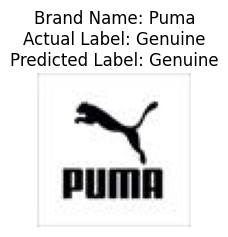

1/1 [==============================] - 0s 44ms/step


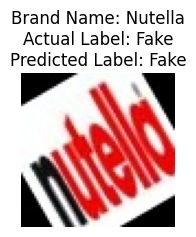

1/1 [==============================] - 0s 42ms/step


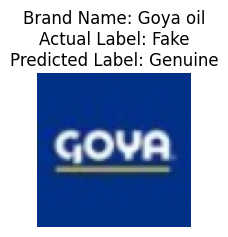

1/1 [==============================] - 0s 49ms/step


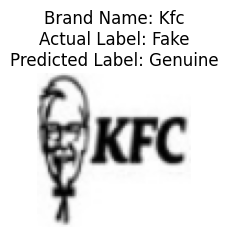

1/1 [==============================] - 0s 66ms/step


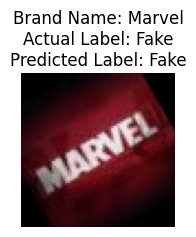

1/1 [==============================] - 0s 35ms/step


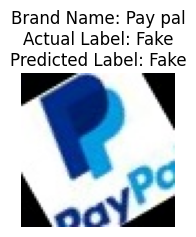

1/1 [==============================] - 0s 33ms/step


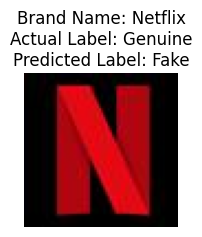

1/1 [==============================] - 0s 35ms/step


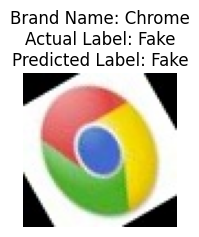

1/1 [==============================] - 0s 34ms/step


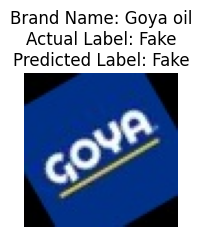

1/1 [==============================] - 0s 34ms/step


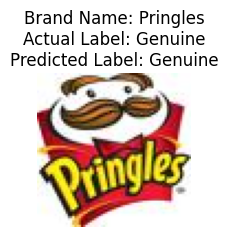

1/1 [==============================] - 0s 35ms/step


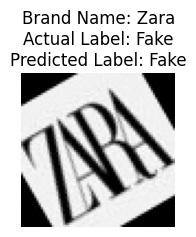

1/1 [==============================] - 0s 39ms/step


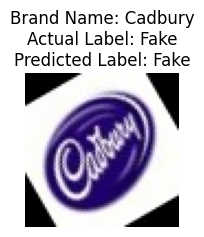

1/1 [==============================] - 0s 38ms/step


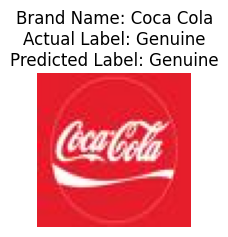

1/1 [==============================] - 0s 36ms/step


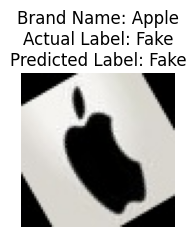

1/1 [==============================] - 0s 35ms/step


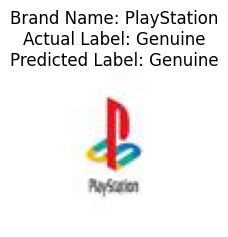

1/1 [==============================] - 0s 40ms/step


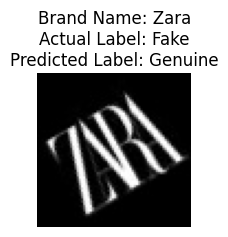

1/1 [==============================] - 0s 35ms/step


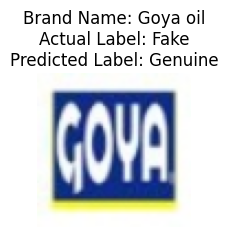

1/1 [==============================] - 0s 34ms/step


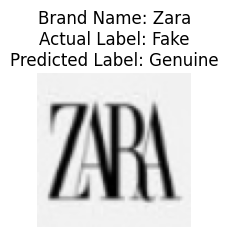

1/1 [==============================] - 0s 39ms/step


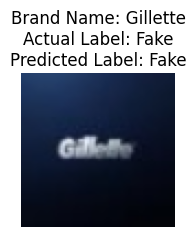

1/1 [==============================] - 0s 51ms/step


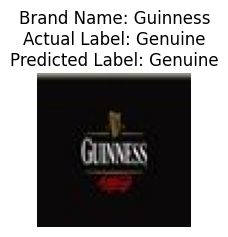

1/1 [==============================] - 0s 36ms/step


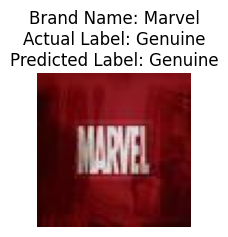

1/1 [==============================] - 0s 36ms/step


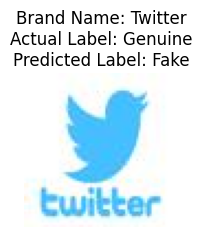

1/1 [==============================] - 0s 37ms/step


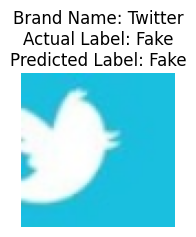

1/1 [==============================] - 0s 34ms/step


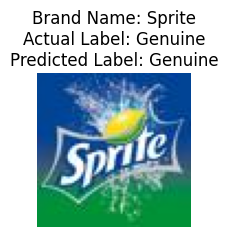

1/1 [==============================] - 0s 34ms/step


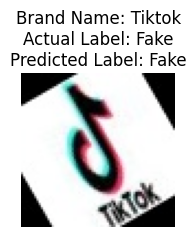

1/1 [==============================] - 0s 37ms/step


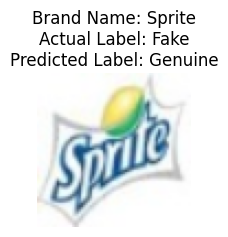

1/1 [==============================] - 0s 37ms/step


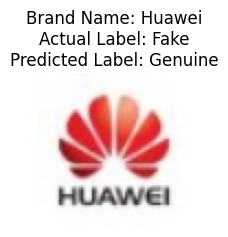

1/1 [==============================] - 0s 36ms/step


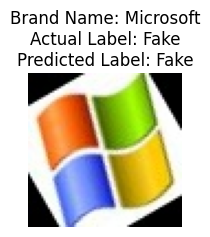

1/1 [==============================] - 0s 37ms/step


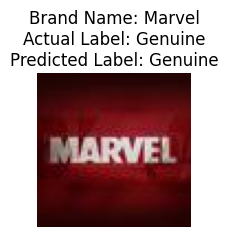

1/1 [==============================] - 0s 37ms/step


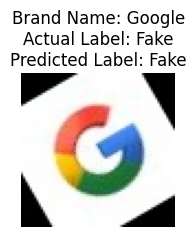

1/1 [==============================] - 0s 35ms/step


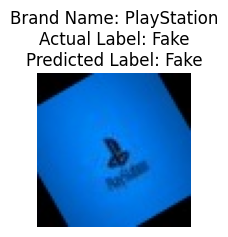

1/1 [==============================] - 0s 42ms/step


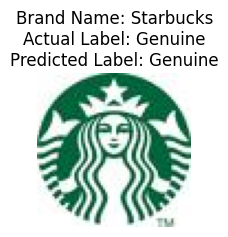

1/1 [==============================] - 0s 37ms/step


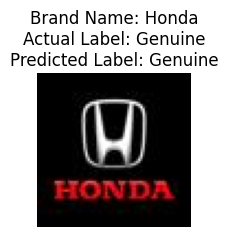

1/1 [==============================] - 0s 40ms/step


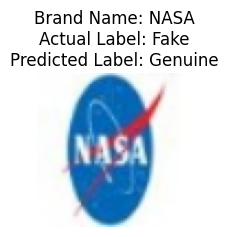

1/1 [==============================] - 0s 46ms/step


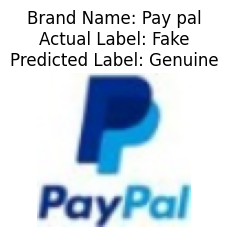

1/1 [==============================] - 0s 43ms/step


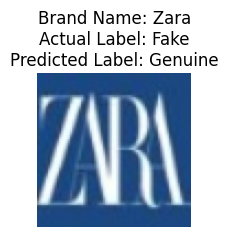

1/1 [==============================] - 0s 46ms/step


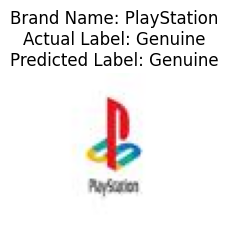

1/1 [==============================] - 0s 53ms/step


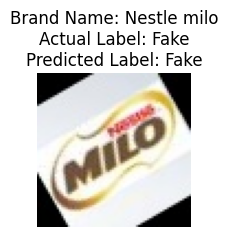

1/1 [==============================] - 0s 40ms/step


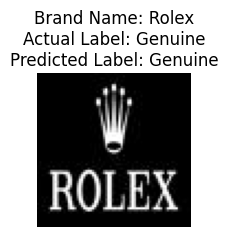

1/1 [==============================] - 0s 50ms/step


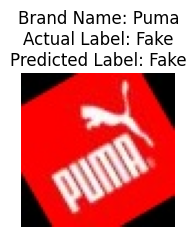

1/1 [==============================] - 0s 49ms/step


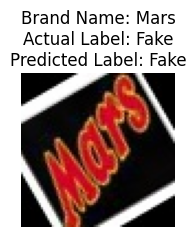

1/1 [==============================] - 0s 48ms/step


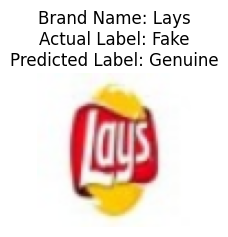

1/1 [==============================] - 0s 81ms/step


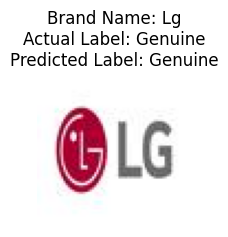

1/1 [==============================] - 0s 43ms/step


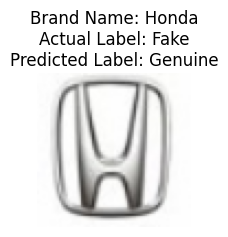

1/1 [==============================] - 0s 72ms/step


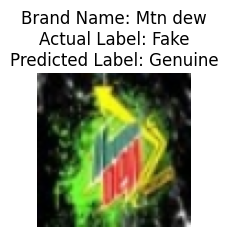

In [ ]:
class_label={
    0:"Fake",
    1:"Genuine"
}
actual_labels = []
predicted_labels = []
for index, row in test_df.iterrows():

    logo_path = row['Filename']
    brand_name= row['Brand Name']
    actual_class_label= row['Label']

    test_img = cv2.imread(logo_path)
    test_img = cv2.resize(test_img,(70,70))
    test_input = test_img.reshape((1,70,70,3))

    predictions = model.predict(test_input)
    predicted_class_label = class_label[int(predictions[0][0])]

    actual_labels.append(actual_class_label)
    predicted_labels.append(predicted_class_label)


    plt.figure(figsize=(2,2))
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Brand Name: {brand_name}\n"
              f"Actual Label: {actual_class_label}\n"
              f"Predicted Label: {predicted_class_label}")
    plt.show()



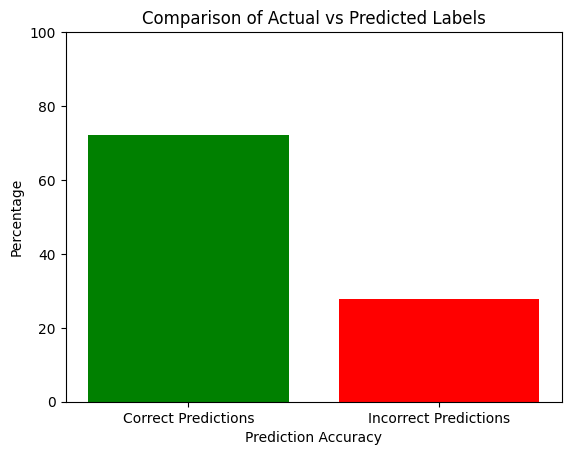

In [ ]:
correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
incorrect_predictions = len(actual_labels) - correct_predictions
total_predictions = len(actual_labels)

# Calculate percentages
correct_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = (incorrect_predictions / total_predictions) * 100

# Plotting the results
labels = ['Correct Predictions', 'Incorrect Predictions']
percentages = [correct_percentage, incorrect_percentage]

plt.bar(labels, percentages, color=['green', 'red'])
plt.xlabel('Prediction Accuracy')
plt.ylabel('Percentage')
plt.title('Comparison of Actual vs Predicted Labels')
plt.ylim(0, 100)
plt.show()

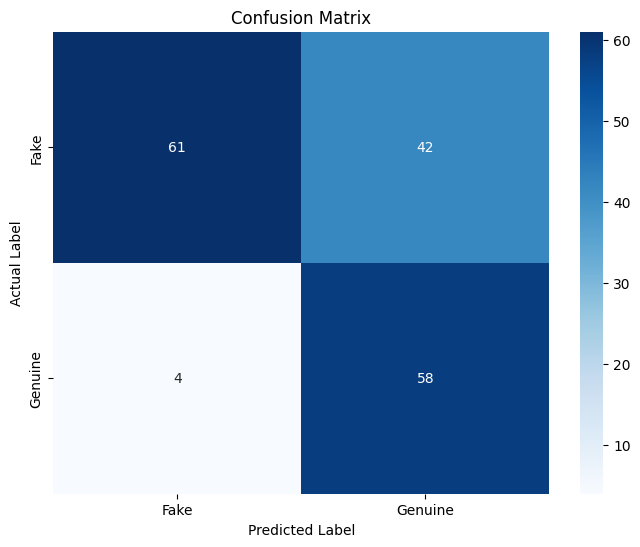

In [ ]:
#Confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#F1 Score
f1 = f1_score(actual_labels, predicted_labels,pos_label='Genuine')
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7160
